# IMDB Review Sentiment Analysis


Data source: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

Code adapted from: https://www.kaggle.com/code/miladlink/imdb-sentiment-analysis-pytorch

In [1]:
#!conda install -c conda-forge spacy
#or
#!pip install -U pip setuptools wheel
#!pip install -U spacy

#then
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

import os
import re
import sys
import time
import spacy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# setup
NLP = spacy.load('en_core_web_sm')  # NLP toolkit

In [2]:
#initialize for random seeds/states
seeds=[12345,42,42]
def randomize(seed_rng=seeds[0], seed_np=seeds[1], seed_torch=seeds[2]):
    os.environ['PYTHONHASHSEED'] = '0'
    rng = np.random.default_rng(seed_rng)
    np.random.seed(seed_np)
    torch.manual_seed(seed_torch)

randomize()

## Explore data

In [3]:
# Read dataset
train_df = pd.read_csv("Train.csv")
valid_df = pd.read_csv("Valid.csv")
test_df = pd.read_csv("Test.csv")

In [4]:
print('number of train:', len(train_df))
print('number of valid:', len(valid_df))
print('number of test:', len(test_df))
train_df.head(3)

number of train: 40000
number of valid: 5000
number of test: 5000


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

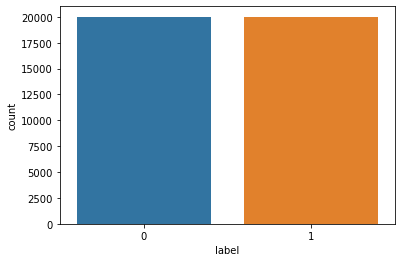

In [5]:
sns.countplot(train_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

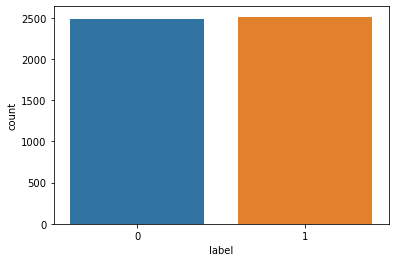

In [6]:
sns.countplot(valid_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

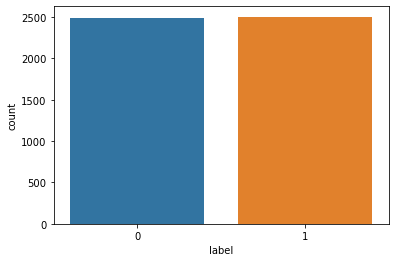

In [7]:
sns.countplot(test_df['label'])

In [8]:
num_words = [len(f.split(' ')) for f in train_df['text']]

# print statistics
print('Min length =', min(num_words))
print('Max length =', max(num_words))

print('Mean = {:.2f}'.format(np.mean(num_words)))
print('Std  = {:.2f}'.format(np.std(num_words)))

print('mean + 1 * sigma = {:.2f}'.format(np.mean(num_words) + 1.0 * np.std(num_words)))

Min length = 4
Max length = 2470
Mean = 231.33
Std  = 171.18
mean + 1 * sigma = 402.51


## Tokenize

In [9]:
use_stopwords = True
stopwords = NLP.Defaults.stop_words if use_stopwords else []
def tokenizer(text, stopwords=stopwords):
    text = re.sub(r"<br /><br />", " ", text)
    text = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;]", " ", str(text))
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub(r"\!+", "!", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\?+", "?", text)
    return [x.text for x in NLP.tokenizer(text) if x.text != " " and (x.text not in stopwords)]

In [10]:
print(stopwords)

{'enough', 'out', 'very', 'thereby', 'another', 'many', 'keep', 'hence', 'a', 'n’t', 'call', 'while', '’ll', 'hereafter', 'amount', 'on', 'ca', 'former', 'seemed', 'side', 'latter', 'whose', 'themselves', "'m", 'hereby', 'their', 'such', 'wherever', 'how', '‘d', 'always', 'towards', 'name', 'empty', 'whenever', 'one', 'nine', "'s", 'yourselves', 'somewhere', 'up', 'made', 'whereby', 'his', 'upon', 'top', 'afterwards', 'here', 'than', 'sometimes', 're', 'serious', 'to', 'might', 'per', 'still', 'herein', 'more', 'never', 'back', 'at', 'them', 'your', 'unless', "'ll", 'once', 'everywhere', 'must', 'sometime', 'both', 'by', 'are', 'due', 'they', 'should', 'became', 'may', 'it', 'hereupon', 'few', '‘re', '’m', 'whole', 'have', 'everyone', 'this', 'did', 'ours', 'mostly', 'often', 'my', 'onto', 'him', 'between', 'seem', 'though', 'several', 'beyond', 'whereas', 'together', 'without', 'whom', 'who', 'were', 'since', 'as', 'further', 'her', 'twelve', '’s', 'already', 'nevertheless', 'whereupo

## Vocab

In [11]:
class Vocabulary(object):
    
    def __init__(self, tokenizer, stopwords=stopwords):
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.count = 0
    
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.count
            self.word2count[word] = 1
            self.index2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1
    
    def add_sentence(self, sentence):
        for word in self.tokenizer(sentence, self.stopwords):
            self.add_word(word)
            
    def __len__(self):
        return self.count

In [12]:
PAD = '<pad>'  # special symbol we use for padding text
UNK = '<unk>'  # special symbol we use for rare or unknown word
CLASSES = ['negative', 'positive']
MAX_LEN = 300     #max input length, if fewer than this, padding is added 
MIN_COUNT = 10    #if frequency rare than this the word is set as unknown
VOCAB_PATH = 'vocab.pkl'
BATCH_SIZE = 25

## Dataset class

In [13]:
class TextClassDataset(Dataset):
    
    def __init__(self, df, tokenizer, classes, vocab_path='vocab.pkl', max_len=100, min_count=10, stopwords=stopwords):
        #assign input---------------
        self.df = df
        self.vocab_path = vocab_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_count = min_count
        self.classes = classes
        self.stopwords = stopwords
        #---------------------------
        self.vocab = None
        self.class_idx = np.unique(df['label'])
        self.class_to_index = {classes[i]: i for i in range(len(classes))}        
        self.num_classes = len(self.classes)
        self.text = df['text']
        # build vocabulary from training and validation texts
        self.build_vocab()
        
    def __getitem__(self, index):        
        # read text file 
        text, label = self.df['text'][index], self.df['label'][index]
        
        # tokenize the text file
        tokens = self.tokenizer(text.lower().strip(), self.stopwords)
        
        # padding and trimming
        if len(tokens) < self.max_len:
            num_pads = self.max_len - len(tokens)
            tokens = tokens + [PAD] * num_pads 
        elif len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            
        # numericalizing
        ids = torch.LongTensor(self.max_len)
        for i, word in enumerate(tokens):
            if word not in self.vocab.word2index:
                ids[i] = self.vocab.word2index[UNK]  # unknown words
            elif word != PAD and self.vocab.word2count[word] < self.min_count:
                ids[i] = self.vocab.word2index[UNK]  # rare words
            else:
                ids[i] = self.vocab.word2index[word]
        
        return ids, label
    
    def __len__(self):
        return len(self.df)
    
    def build_vocab(self):
        if not os.path.exists(self.vocab_path):
            vocab = Vocabulary(self.tokenizer)
            for f in self.df['text']:
                for line in f.split('\n'):
                    vocab.add_sentence(line.lower())
            # sort words by their frequencies--------
            words = [(0, PAD), (0, UNK)]
            words += sorted([(c, w) for w, c in vocab.word2count.items()], reverse=True)

            self.vocab = Vocabulary(self.tokenizer)
            for i, (count, word) in enumerate(words):
                self.vocab.word2index[word] = i
                self.vocab.word2count[word] = count
                self.vocab.index2word[i] = word
                self.vocab.count += 1
            
            pickle.dump(self.vocab, open(self.vocab_path, 'wb'))
        else:
            self.vocab = pickle.load(open(self.vocab_path, 'rb'))

### Set dataloader

In [14]:
train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Explore data after processed

In [15]:
print('text shape:', train_ds[0][0].shape)
print('text shape:', train_ds[0][1].shape)
print('number of texts:', len(train_ds))
print(train_ds.classes)
print(train_ds.class_to_index)

text shape: torch.Size([300])
text shape: ()
number of texts: 40000
['negative', 'positive']
{'negative': 0, 'positive': 1}


In [16]:
# convert back the sequence of integers into original text
print(' '.join([train_ds.vocab.index2word[i.item()] for i in train_ds[1][0]]))

movie dvd player , sat coke chips , expectations . hoping movie contain strong points movie awsome animation , good flowing story , excellent voice cast , funny comedy kick ass soundtrack . , disappointment , found atlantis milo return . read reviews , let . following paragraph directed seen movie , enjoyed primarily points mentioned . scene appears , shock picked atlantis milo return display case local <unk> , expectations . music feels bad imitation movie , voice cast replaced fitting . exception characters , like voice sweet . actual drawings nt bad , animation particular sad sight . storyline pretty weak , like episodes <unk> doo single adventurous story got time . nt misunderstand , good <unk> doo episodes . nt laugh single time , <unk> twice . audience seen movie , especially care similar sequel , fast review movie stand product liked <unk> doo , like movie . , enjoy movie . suspect good kids movie , know . better milo return episode series cartoon channel , breakfast tv . <pad> 

In [17]:
# print the original text
print(train_ds.text[1])

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, b

In [18]:
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
vocab_size = len(freqs) + 2  # for PAD and UNK tokens
print(f'Vocab size = {vocab_size}')

print('\nMost common words:')
for c, w in sorted(freqs, reverse=True)[:10]:
    print(f'{w}: {c}')

Vocab size = 25206

Most common words:
.: 437232
,: 435318
movie: 70331
film: 63527
like: 32272
!: 30453
': 27010
good: 23858
?: 23680
time: 20108


## Neural Networks

In [19]:
# Attention computes a weighted average of the hidden states of the LSTM Model.
# In fact, it produce a weight for each hidden state at different time steps

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )
    def forward(self, encoder_outputs):
        # encoder_outputs = [batch size, sent len, hid dim]
        energy = self.projection(encoder_outputs)
        # energy = [batch size, sent len, 1]
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # weights = [batch size, sent len]
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        # outputs = [batch size, hid dim]
        return outputs, weights

In [20]:
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, 
                            dropout= 0 if n_layers < 2 else dropout)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x = [sent len, batch size]
        embedded = self.embedding(x)
        # embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.lstm(embedded)
        # use 'batch_first' if you want batch size to be the 1st para
        # output = [sent len, batch size, hid dim*num directions]
        output = output[:, :, :self.hidden_dim] + output[:, :, self.hidden_dim:]
        # output = [sent len, batch size, hid dim]
        ouput = output.permute(1, 0, 2)
        # ouput = [batch size, sent len, hid dim]
        new_embed, weights = self.attention(ouput)
        # new_embed = [batch size, hid dim]
        # weights = [batch size, sent len]
        new_embed = self.dropout(new_embed)
        return self.fc(new_embed)

## Training helper functions

In [21]:
def train_one(model, loader, loss_fn, optimizer, metric_fn, device):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    metrics = 0.0
    steps = len(loader)

    for i, (inputs, labels) in enumerate(loader):
        # Place to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.zero_grad()
        outputs = model(inputs.t())
        # Calculate loss
        loss = loss_fn(outputs, labels)
        losses += loss
        # Backpropagation and update weights
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()
        # Calculate metrics
        metric = metric_fn(outputs, labels)
        metrics += metric
        # report
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), metric))
    
    sys.stdout.write ('\r')
    return losses.item() / len(loader), metrics / len(loader)

In [22]:
def accuracy(outputs, labels):
    """ calculate percent of true labels """
    # predicted labels
    _, preds = torch.max(outputs, dim = 1)
    return torch.sum(preds == labels).item() / len(preds)

In [23]:
def evaluate(model, loader, loss_fn, metric_fn, device):
    """ Evaluate trained weights using calculate loss and metrics """
    # Evaluate model
    model.eval()
    losses = 0.0
    metrics = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.t())
            loss = loss_fn(outputs, labels)
            losses += loss
            metrics += metric_fn(outputs, labels)
    return losses.item() / len(loader), metrics / len(loader)

In [24]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs, metric_fn, device, checkpoint_path, scheduler=None, load_model=False, prev_best_loss=None):
    """ fiting model to dataloaders, saving best weights and showing results """
    # to continue training from saved weights
    if load_model:
        load_checkpoint(torch.load(checkpoint_path), model)
    if prev_best_loss is None:
        best_loss = 1000000
    else:
        best_loss = prev_best_loss
    losses, val_losses, accs, val_accs = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        loss, acc = train_one(model, train_dl, loss_fn, optimizer, metric_fn, device)
        val_loss, val_acc = evaluate (model, valid_dl, loss_fn, metric_fn, device)
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        # learning rate scheduler------
        if scheduler is not None:
            scheduler.step()
        # save weights if improved-----
        if val_loss < best_loss:
            best_loss = val_loss
            best_wts = model.state_dict().copy()
            torch.save(best_wts, checkpoint_path)
            print('Checkpoint Saved! Epoch {} is better.***************************'.format(epoch+1))
        print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, num_epochs, loss, acc, val_loss, val_acc))

    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format (period // 60, period % 60))
    model.load_state_dict(best_wts)
    return dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs)

## Train

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [26]:
# LSTM parameters
EMBED_SIZE = 256
HIDDEN_SIZE = 1024
NUM_LAYERS = 1

# training parameters
LR = 0.001
NUM_EPOCHS = 2
CHECKPOINT_PATH = 'IMDB_Normal.pth'

In [27]:
model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, train_ds.num_classes, NUM_LAYERS, bidirectional=True, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [28]:
history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, DEVICE, CHECKPOINT_PATH, scheduler)

Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 0.3999 - acc: 0.8146 - val_loss: 0.2825 - val_acc: 0.8784
Epoch [2/2], loss: 0.2176 - acc: 0.9169 - val_loss: 0.2867 - val_acc: 0.8946
Training complete in 5m 20s


## Test

In [29]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

<All keys matched successfully>

In [30]:
evaluate(model, test_dl, loss_fn, accuracy, DEVICE)

(0.29209945678710936, 0.8821999999999997)

In [31]:
def gen_base(BATCH_SIZE, MAX_LEN, MIN_COUNT, stopwords=stopwords, NUM_EPOCHS=2):
    train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, train_ds.num_classes, NUM_LAYERS, bidirectional=True, dropout=0.5).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    randomize()
    history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, DEVICE, CHECKPOINT_PATH, scheduler)
    return history, model

In [32]:
history, model = gen_base(BATCH_SIZE, MAX_LEN, MIN_COUNT, NUM_EPOCHS=NUM_EPOCHS)

Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 0.3688 - acc: 0.8365 - val_loss: 0.3114 - val_acc: 0.8640
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 0.2122 - acc: 0.9206 - val_loss: 0.2814 - val_acc: 0.8970
Training complete in 5m 9s


In [ ]:
NUM_EPOCHS=2
history={}
model={}
#torch.Backends.Cudnn.Enabled = False
for BATCH_SIZE in [16, 25, 50]:
    for MAX_LEN in [300, 400, 500]:
        for MIN_COUNT in [10, 20]:
            print('BATCH_SIZE: {}; MAX_LEN: {}; MIN_COUNT: {}'.format(BATCH_SIZE, MAX_LEN, MIN_COUNT),'------------------------------------------')
            key = 'b'+str(BATCH_SIZE)+'max'+str(MAX_LEN)+'min'+str(MIN_COUNT)
            history[key], model[key] = gen_base(BATCH_SIZE, MAX_LEN, MIN_COUNT, NUM_EPOCHS=NUM_EPOCHS)

### confusion matrix, plot to be made...

###  explore some wrong predictions...